# Introduction

Actor-Critic has a significant deficiency: since the actor is DNN, when the step size is large, it could be very possible that the policy suddenly gets worse significantly. Targetting at this problem, let us consider to find a trust region where the safety of update is somehow guaranteed. This is the core idea of Trust Region Policy Optimization (TRPO). TRPO is introduced in 2015, it can theoratically prove the monotonicity of the policy learning, and shows better performance compared to Policy Gradient.

# Policy Target
Detailed proof see [Trust Region Policy Optimization](https://arxiv.org/pdf/1502.05477).

The target we will optimize is:
$$\theta_{k+1} = \arg \max_{\theta'} g^T (\theta' - \theta_k) \text{ s.t. } \frac{1}{2} (\theta' - \theta_k)^T H  (\theta' - \theta_k) \leq \delta,$$

where $g = \nabla_{\theta'}\mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot|s)} [\frac{\pi_{\theta'}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s, a)]$ is the gradient, and $H = \textbf{H}[\mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot|s)||\pi_{\theta'}(\cdot|s))]]$ is the Hessian matrix. 

We can use Karush-Kuhn-Tucker (KKT) condition to directly get the solution:
$$\theta_{k+1} = \theta_{k} + \sqrt{\frac{2\delta}{g^TH^{-1}g}}H^{-1}g$$

## Conjugate Gradient
Calculate the Hessian matrix could be costly. TRPO uses the conjugate gradient method to avoid directly calculate the Hessian matrix. The core idea is to calculate $x=H^{-1}g$ instead, where $x$ is the diretion of update. Assume the maximum stepsize of the update is $\beta$. According to the constraint condition, we have $\frac{1}{2}(\beta x)^T H (\beta x) = \delta$. Solve for $\beta$, we get $\beta = \sqrt{\frac{2\delta}{x^THx}}$.Therefore, we can directly update $\theta$ by: $$\theta_{k+1} = \theta{k} + \sqrt{\frac{2\delta}{x^T H x}}x$$.

Therefore, as long as we have $x = H^{-1}g$, we can calculate the update without generate the full Hassian matrix. Since Hassian matrix is positive-definite, we can use the conjugate gradient method to solve it. The details are in below:
- Init $r_0 = g-Hx_0, p_0=r_0, x_0=0$
- for $k = 0 \rightarrow N$ do:
    - $\alpha = \frac{r^T_kr_k}{p^T_kHp_k}$
    - $x_{k+1} = x_k + \alpha_k p_k$
    - $r_{k+1} = r_k - \alpha_k H p_k$
    - if $r_{k+1}^T r_{k+1}$ is small enough, end loop
    - $\beta = \frac{r_{k+1}^T r_{k+1}}{r_{k}^T r_{k}}$
    - $p_{k+1} = r_{k+1} + \beta_k p_k$
- end for
- output $x_{N+1}$

To avoid calculate $H$, instead we calculate $Hx$. It is easy to prove that $$Hv = \nabla_\theta((\nabla_\theta(D^{\nu^{\pi_{\theta_k}}}_{KL}))^T)v = \nabla_\theta((\nabla_\theta(D^{\nu^{\pi_{\theta_k}}}_{KL}))^T v)$$
namely first do dot product then differentiation.

# Linear Search

Since TRPO adopts Talor's first and second order expansion, we cannot guarantee $\theta'$ is better than $\theta$. Therefore at the end of each iteration, TRPO do a linear seach to ensure $\theta'$ will not get worse. To be specific, it is to find the smallest nonnegative coefficeint $i$ s.t. $$\theta_{k+1} = \theta_k + \alpha^i \sqrt{\frac{2\sigma}{x^THx}}x$$

The solution $\theta_{k+1}$ still satisfies the initial KL divergence constraints. Plus, it improves the target $L_{\theta_k}$, among which $\alpha \in (0,1)$ is a hyperparameter that decides the length of linear search.

Till now, we have make it clear the whole procedure of TRPO. Let's do a summarization:

- init policy params $\theta$ and value params $\omega$
- for sequence $e = 1 \rightarrow E$ do:
    - under current policy $\pi_\theta$ sample a trajectory $\{s_1, a_1, r_1, s_2, a_2, r_2, ...\}$
    - calculate the advantage of each state-action pair based on the sampled data and value net $A(s_t, a_t)$
    - calculate the gradient for the policy $g$
    - find $i$ by linear search, update the policy by $\theta_{k+1} = \theta_k + \alpha^i \sqrt{\frac{2\sigma}{x^THx}}x$ where $i \in \mathbb{R}^+$ is the minimal positive integer that improves the policy and satisfies the constraint of KL divergence
    - update the value net params $\omega$: $\omega = \omega + \alpha_\omega \sum_{t} \delta_t \nabla_\omega V_\omega(t)$ (the same as in actor-critic)
- end for

# Generalized Advantage Estimation
The above algorithm does not tell use how to estimate the advantage $A$. One common method is to use the Generalized Advantage Esitmation (GAE). Below we shortly introduce GAE. 

To begin with, we have TD error $\delta = r_t + \gamma V_{t+1} - V_t$. According to the stps we used for estimation, we have:

$$A^{(1)}_t = \delta_t = r_t + \gamma V_{t+1} - V_t$$
$$A^{(2)}_t = \delta_t + \gamma \delta_{t+1} = r_t + \gamma r_{t+1} + \gamma^2 V_{t+2} - V_t$$
$$A^{(3)}_t = \delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 V_{t+3} - V_t$$
$$...$$
$$A^{(k)}_t = \sum^{k-1}_{l=0} \gamma^l \delta_{t+l} = \gamma^k V_{t+k} - V_t + \sum_{l=0}^{k-1} \gamma^l r_{t+l}$$

Then, GAE do an exponential weighted average (EMA) on all the advantage estimations:
$$A^{GAE}_t = (1-\lambda) (A_t^{(1)} + \lambda A_t^{(2)} + \lambda^2 A_t^{(3)} + ...) \\ \quad = (1-\lambda) (\delta_t + \lambda(\delta_t + \gamma \delta_{t+1}) + \lambda^2(\delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2}) + ...) \\ \quad = (1-\lambda) (\delta_t(1+ \lambda + \lambda^2 + ...) + \gamma\delta_{t+1}(\lambda + \lambda^2 + \lambda^3 + ...) + \gamma^2 \delta_{t+2}(\lambda^2 + \lambda^3 + \lambda^4 + ...) + ...) \\ \quad = (1-\lambda) (\delta_t\frac{1}{1-\lambda} + \gamma\delta_{t+1}\frac{\lambda}{1-\lambda} + \gamma^2\delta_{t+2}\frac{\lambda^2}{1-\lambda} + ...) \\ \quad = \sum_{l=0}^\infty (\gamma \lambda)^l \delta_{t+l}$$

where $\lambda \in [0, 1]$ is a hyperparameter. When $\lambda = 0$, $A^{GAE}_{t} = \delta_t = r_t = \gamma V_{t+1} - V_t$, which is just one-step advantage. When $\lambda=1$, $A^{GAE}_{t} = \sum_{l=0}^\infty \gamma^l \delta_{t+l} = \sum_{l=0}^\infty \gamma^l - V_t$ is the average of all the step advantages.

To begin with the code, we start at implementing GAE.

In [1]:
import numpy as np
np.bool8 = np.bool_
import torch
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [28]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

Then we define the networks (the same as in actor-critic).

In [29]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))  # 计算平均KL距离
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):  # 更新策略函数
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()

        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))

        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict['terminated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -terminated) * (1-truncated)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

Iteration 9: 100%|██████████| 50/50 [00:01<00:00, 47.85it/s, episode=500, return=200.000]


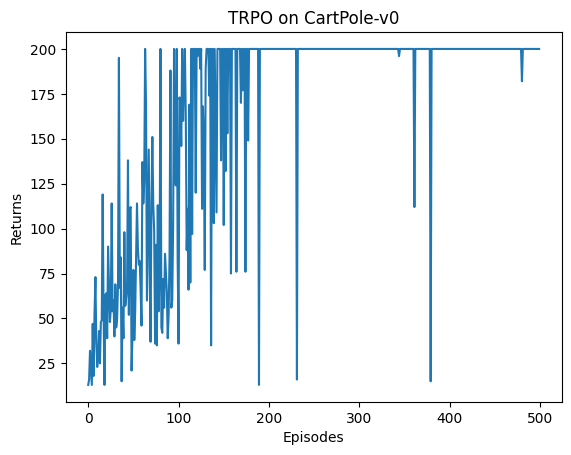

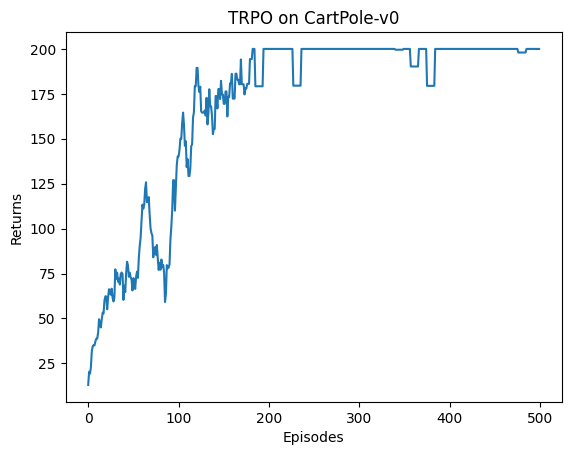

In [30]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

In [31]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差


class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict['terminated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - terminated) * (1 - truncated)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|██████████| 200/200 [00:03<00:00, 50.33it/s, episode=2000, return=-281.162]


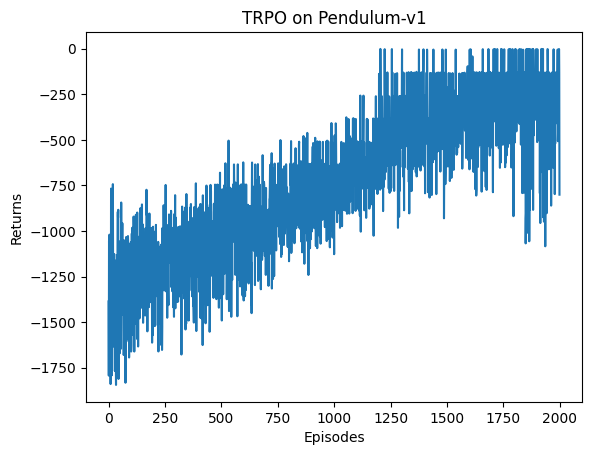

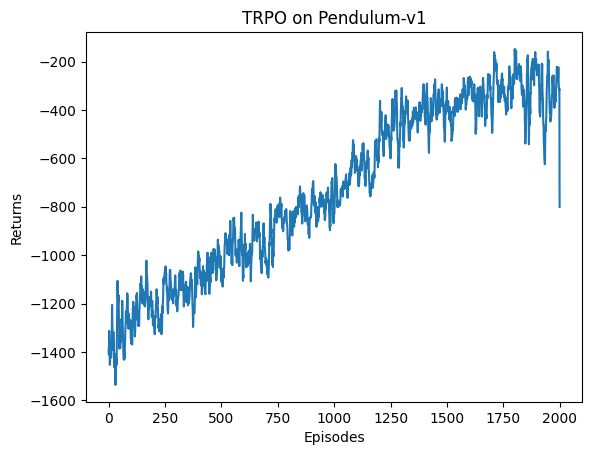

In [33]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()